In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import sklearn
import sys
!{sys.executable} -m pip install tensorflow
import tensorflow as tf
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tqdm import tqdm



In [2]:
from google.colab import files
uploaded= files.upload()

Saving TCS_stock_history.csv to TCS_stock_history.csv


In [17]:
import pandas as pd
TCS=pd.read_csv("TCS_stock_history.csv")
TCS.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0


In [6]:
model = Sequential()
model.add(LSTM(50, input_shape=(1, 1)))
model.add(Dense(1))


In [20]:
 # Prepare the data for LSTM
 X_train = TCS["Close"].values.reshape(-1, 1)
 y_train = TCS["Close"].shift(-1).dropna().values

# Normalize the data
 from sklearn.preprocessing import MinMaxScaler
 scaler = MinMaxScaler()
 X_train_scaled = scaler.fit_transform(X_train)

# Define the test data
 test_ratio = 0.2
 test_size = int(len(TCS) * test_ratio)
 test_data = TCS[-test_size:]

# Prepare the data for prediction
 X_test = test_data["Close"].values.reshape(-1, 1)
 X_test_scaled = scaler.transform(X_test)
 X_test_lstm = X_test_scaled.reshape(-1, 1, 1)


In [19]:
X_train_lstm = X_train_scaled[:-1].reshape(-1, 1, 1)
y_train_lstm = X_train_scaled[1:]

In [21]:
 model.compile(optimizer='adam', loss='mean_squared_error')
 # Set the number of epochs and batch size
 epochs = 30
 batch_size = 15
 # Train the model with tqdm progress bar
 for epoch in tqdm(range(epochs)):
    for i in range(0, len(X_train_lstm), batch_size):
        X_batch = X_train_lstm[i:i+batch_size]
        y_batch = y_train_lstm[i:i+batch_size]
        model.train_on_batch(X_batch, y_batch)

100%|██████████| 30/30 [00:10<00:00,  2.77it/s]


In [22]:
lstm_predictions = model.predict(X_test_lstm).flatten()

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [24]:
 lstm_predictions = lstm_predictions.reshape(-1, 1)
 lstm_predictions = scaler.inverse_transform(lstm_predictions)


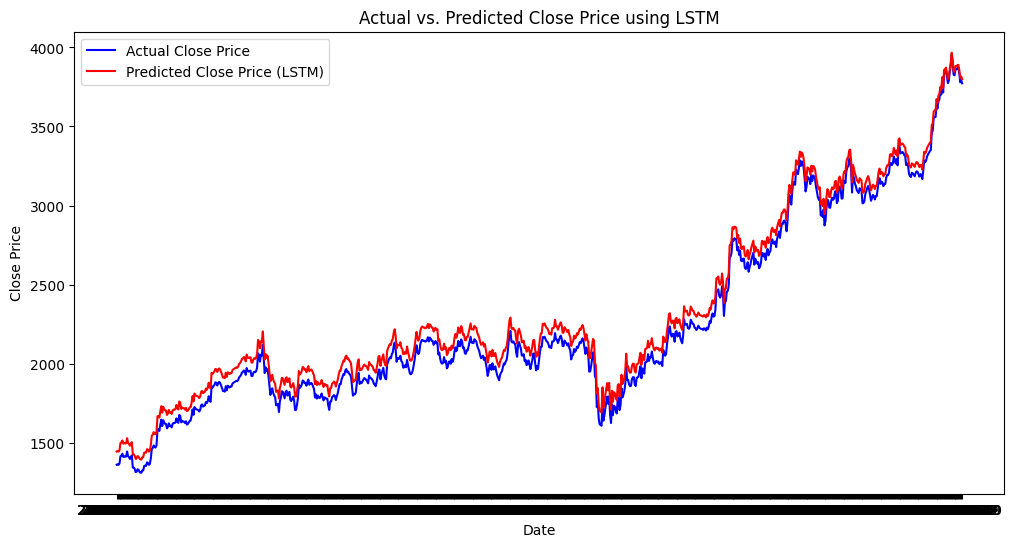

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(test_data['Date'], test_data['Close'], label='Actual Close Price', color='b')
plt.plot(test_data['Date'], lstm_predictions, label='Predicted Close Price (LSTM)', color='r')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs. Predicted Close Price using LSTM')
plt.legend()
plt.show()

In [30]:
 lstm_mae = mean_absolute_error(test_data['Close'],
 lstm_predictions)
 print("LSTM Mean Absolute Error:", lstm_mae)

LSTM Mean Absolute Error: 77.90980919808015


In [31]:
 lstm_predictions = lstm_predictions.reshape(-1, 1)
 lstm_predictions = scaler.inverse_transform(lstm_predictions)
date_index=test_data.index[-len(lstm_predictions):]
 predictions_df=pd.DataFrame({'Date':date_index,
 'Predicted_Close':lstm_predictions.flatten()})
 predictions_df.to_csv('predictions.csv',index=False)